<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/visualization_xrd_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# スペクトルデータの分析を行う

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、material_projects_maked_xrd_pattern_cubic_noncubic.zipをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

In [3]:
# material_projects_maked_xrd_pattern_cubic_noncubic.zipを以下のコマンドで解凍する
! unzip material_projects_maked_xrd_pattern_cubic_noncubic.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-10679_Ba.cif_xrd_pattern.csv  
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-1068325_Sr(InHg)2.cif_xrd_pattern.csv  
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-10687_LiCdP.cif_xrd_pattern.csv  
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-1069079_FeBiO3.cif_xrd_pattern.csv  
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-1069193_Pd(NCl)2.cif_xrd_pattern.csv  
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-1069723_U(CuAs)2.cif_xrd_pattern.csv  
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-1069726_Pd(NCl)2.cif_xrd_pattern.csv  
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-1069811_Hf2H2Pd.cif_xrd_pattern.csv  
  inflating: material_projects_maked_xrd_pattern_not_cubic_csv/cif_mp-1072086_TaS2.cif_xrd_pattern.csv  
  infl

## ライブラリをインポート

In [4]:
! pip install lightgbm==4.2.0
! pip install scikit-learn==1.3.2 #ライブラリのverによっては次元圧縮の挙動が異なることがあるため注意
! pip install numpy==1.26.4
! pip install pandas==2.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [5]:
import glob
import os
import warnings

warnings.filterwarnings("ignore")

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

## material_projects_maked_xrd_pattern_cubicに格納されているファイルを確認

In [6]:
files_cubic = glob.glob(INPUT_FILE_PATH + "material_projects_maked_xrd_pattern_cubic_csv/*.csv")
len(files_cubic)

4575

In [7]:
# データフレームのリストを作成
df_cubic = [pd.read_csv(file_path) for file_path in files_cubic]

In [8]:
# df_cubicの1つ目を表示
df_cubic[0]

,2theta,Intensity
0,5.00,0.003802
1,5.01,0.003805
2,5.02,0.003808
3,5.03,0.003810
4,5.04,0.003813
...,...,...
9495,99.95,0.005181
9496,99.96,0.005175
9497,99.97,0.005168
9498,99.98,0.005162


## material_projects_maked_xrd_pattern_not_cubicに格納されているファイルを確認

In [9]:
# ファイルのリストを取得
files_not_cubic = glob.glob(
    INPUT_FILE_PATH + "material_projects_maked_xrd_pattern_not_cubic_csv/*.csv"
)
len(files_not_cubic)

5425

In [10]:
# データフレームのリストを作成
df_not_cubic = [pd.read_csv(file_path) for file_path in files_not_cubic]

In [11]:
# df_not_cubicの1つ目を表示
df_not_cubic[0]

,2theta,Intensity
0,5.00,0.064799
1,5.01,0.064946
2,5.02,0.065094
3,5.03,0.065242
4,5.04,0.065391
...,...,...
9495,99.95,0.017274
9496,99.96,0.017260
9497,99.97,0.017245
9498,99.98,0.017230


## cubic構造のデータとnon-cubic構造のデータとで共通の2θ範囲を設定

In [12]:
# 同じ2theta範囲を取得
theta_min = max(
    max(df["2theta"].min() for df in df_cubic),
    max(df["2theta"].min() for df in df_not_cubic),
)
theta_max = min(
    min(df["2theta"].max() for df in df_cubic),
    min(df["2theta"].max() for df in df_not_cubic),
)
common_2theta = np.arange(theta_min, theta_max + 0.01, 0.01)

In [13]:
# common_2thetaを表示
print(common_2theta)

[ 5.    5.01  5.02 ... 99.97 99.98 99.99]


In [14]:
# 両方のデータを共通の2theta範囲に内挿
interpolated_data_cubic = []
for df in df_cubic:
    interpolated_intensity = np.interp(common_2theta, df["2theta"], df["Intensity"])
    interpolated_data_cubic.append(interpolated_intensity)

interpolated_data_not_cubic = []
for df in df_not_cubic:
    interpolated_intensity = np.interp(common_2theta, df["2theta"], df["Intensity"])
    interpolated_data_not_cubic.append(interpolated_intensity)

# データを1つの行列に統合
data_matrix_cubic = np.array(interpolated_data_cubic)
data_matrix_not_cubic = np.array(interpolated_data_not_cubic)

## cubic構造のデータとnon-cubic構造のデータとを連結させてPCAを実行

In [15]:
# 両方のデータを連結
combined_data_matrix = np.vstack([data_matrix_cubic, data_matrix_not_cubic])

# PCAを実行
pca = PCA(n_components=2, random_state=42)
pca_result_combined = pca.fit_transform(combined_data_matrix)

# 分割してデータフレームに戻す
pca_result_cubic = pca_result_combined[: len(data_matrix_cubic)]
pca_result_not_cubic = pca_result_combined[len(data_matrix_cubic) :]

pca_df_cubic = pd.DataFrame(pca_result_cubic, columns=["PC1", "PC2"])
pca_df_not_cubic = pd.DataFrame(pca_result_not_cubic, columns=["PC1", "PC2"])

In [16]:
pca_df_cubic

,PC1,PC2
0,-387.304177,622.349062
1,-426.924918,225.016404
2,-575.474663,171.580740
3,-27.813783,111.123251
4,-157.516764,-97.021245
...,...,...
4570,-570.775333,2.061514
4571,-653.513832,321.580727
4572,-142.198067,741.672569
4573,-530.940196,-168.024261


In [17]:
pca_df_not_cubic

,PC1,PC2
0,1382.065879,-82.183683
1,1496.442215,-935.488394
2,105.136207,-402.963818
3,-129.167644,259.354347
4,-31.166617,-69.394408
...,...,...
5420,1854.852413,-1029.884837
5421,932.264198,1803.104739
5422,1209.605653,-138.305160
5423,-482.666680,-78.808220


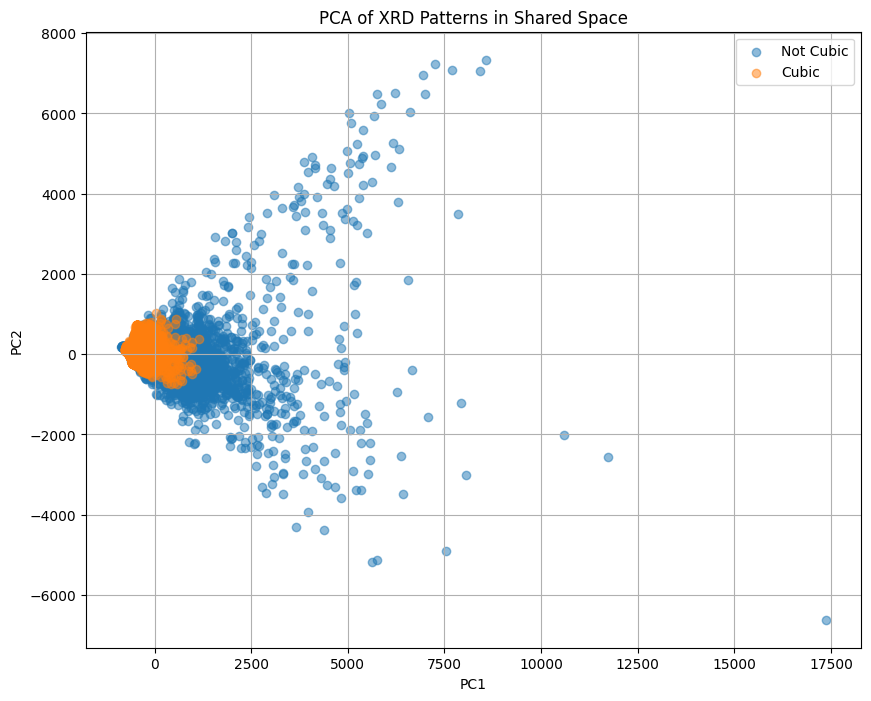

In [18]:
plt.figure(figsize=(10, 8))

plt.scatter(
    pca_df_not_cubic["PC1"],
    pca_df_not_cubic["PC2"],
    alpha=0.5,
    label="Not Cubic",
)

plt.scatter(
    pca_df_cubic["PC1"],
    pca_df_cubic["PC2"],
    alpha=0.5,
    label="Cubic",
)

plt.legend()
plt.title("PCA of XRD Patterns in Shared Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## cubic構造のデータとnon-cubic構造のデータの分類タスクを行う

In [19]:
params = {
    "objective": "binary",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42,
    "max_depth": 5,
    "n_estimators": 1000,
    "colsample_bytree": 0.7,
    "is_unbalance": True,
}

In [20]:
# pca_dfをPositive、pca_df_をNegativeとしてラベルを付与
pca_df_cubic["Label"] = "Positive"
pca_df_not_cubic["Label"] = "Negative"

# PositiveとNegativeのデータを結合
pca_df_all = pd.concat([pca_df_cubic, pca_df_not_cubic], ignore_index=True)

# データを説明変数と目的変数に分割
X = pca_df_all[["PC1", "PC2"]]
y = pca_df_all["Label"]

# データを学習用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルを作成
model = lgbm.LGBMClassifier(**params, verbose=-1)  # ログ出力を抑制

# モデルを学習
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lgbm.early_stopping(stopping_rounds=10)],
)

# テストデータで予測
y_pred = model.predict(X_test)

# 正解率を計算
accuracy = accuracy_score(y_test, y_pred)

# 正解率を表示
print(f"正解率: {accuracy:.2f}")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[660]	valid_0's rmse: 0.399931	valid_0's binary_logloss: 0.481221
正解率: 0.76


In [21]:
# F1スコア、適合率、再現率を計算
f1 = f1_score(y_test, y_pred, pos_label="Positive")
precision = precision_score(y_test, y_pred, pos_label="Positive")
recall = recall_score(y_test, y_pred, pos_label="Positive")

# F1スコア、適合率、再現率を表示
print(f"F1スコア: {f1:.2f}")
print(f"適合率: {precision:.2f}")
print(f"再現率: {recall:.2f}")

F1スコア: 0.76
適合率: 0.71
再現率: 0.82


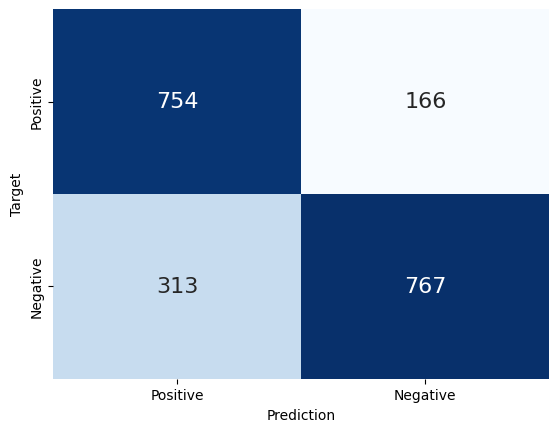

In [22]:
# 混同行列を計算
cm = confusion_matrix(y_test, y_pred)

# confusion matrixを左上がTrue Positive、右上がFalse Positive、左下がFalse Negative、右下がTrue Negativeになるように可視化
sns.heatmap(
    cm[::-1, ::-1],
    annot=True,
    cmap="Blues",
    fmt="d",
    cbar=False,
    annot_kws={"size": 16},
)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.xticks([0.5, 1.5], ["Positive", "Negative"])
plt.yticks([0.5, 1.5], ["Positive", "Negative"])
plt.show()

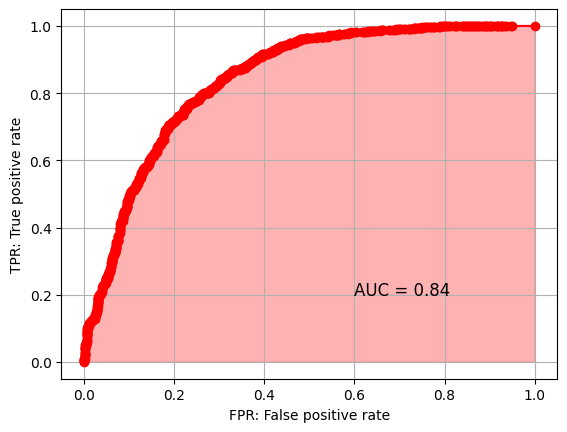

In [23]:
# テストデータで予測
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label="Positive")

# AUCを計算
auc = roc_auc_score(y_test, y_pred_proba)

# ROC曲線を表示
plt.plot(fpr, tpr, marker="o", color="r")
plt.fill_between(fpr, tpr, color="r", alpha=0.3)
plt.xlabel("FPR: False positive rate")
plt.ylabel("TPR: True positive rate")
plt.grid()
plt.text(0.6, 0.2, f"AUC = {auc:.2f}", fontsize=12)
plt.show()

## 実行環境のライブラリverを保存

In [24]:
# Pythonのverを確認
!python3 -V

Python 3.11.11


In [25]:
!pip freeze > requirements_visualization_xrd_map.txt

In [26]:
from google.colab import files

files.download('requirements_visualization_xrd_map.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>